# Introduction

This project focuses on analyzing the **Spaceship Titanic Dataset** to develop a _machine learning model_ that can predict which passengers were transported to an alternate dimension during a collision with a spacetime anomaly. Set in the year 2912, this futuristic scenario presents a unique challenge in the field of data science and interstellar travel safety.

The dataset contains various attributes about the passengers including:

- Demographics
  - Age
  - Name
- Travel Information
  - Home Planet
  - Destination
  - Cabin location
- Onboard Activities
  - RoomService
  - FoodCourt
  - ShoppingMall
  - Spa
  - VRDeck
- Special Statuses
  - VIP
  - CryoSleep

The target variable is whether the passenger was `Transported` to an alternate dimension.

As data scientists working with **Interstellar Rescue Operations**, our objective is to thoroughly explore this data to uncover patterns and insights that can inform the development of a robust predictive model. This will enable rescue crews to identify which passengers were transported and focus their retrieval efforts accordingly.

The analysis will progress through the following key steps:

1. **Exploratory Data Analysis** - Examining the distributions, ranges, and relationships between the features and target variable through statistical summaries and visualizations. Checking data quality and identifying any anomalies in the spaceship's records.

2. **Statistical Inference** - Formulating and testing hypotheses about transportation risk factors and quantifying uncertainty through confidence intervals.

3. **Machine Learning Modeling** - Applying a range of classification algorithms including random forests, gradient boosting, and potentially neural networks to predict transportation likelihood. Tuning hyperparameters and building ensembles to optimize predictive performance.

4. **Model Deployment** - Selecting the top performing model and preparing it for deployment to enable efficient identification of transported passengers in future space anomaly encounters.

Throughout this notebook, detailed commentary will be provided on the analytical approach, key findings, model results and ideas for further enhancement. The goal is to demonstrate a thoughtful, thorough analysis while documenting reproducible steps from data intake through model evaluation.

By accurately predicting which passengers were transported, this project aims to assist rescue operations in efficiently locating and retrieving lost travelers, potentially saving thousands of lives.

_Let's begin the analysis to uncover the mysteries hidden in the Spaceship Titanic's data._


In [1]:
import warnings
from pprint import pprint
import os

import h2o
import matplotlib.pyplot as plt
import joblib
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import seaborn as sns
import shap
import xgboost as xgb
from h2o.automl import H2OAutoML
from IPython.display import Image
from lightgbm import LGBMClassifier
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
)
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from optuna.integration import XGBoostPruningCallback

from spaceship_titanic.advanced_visualizations_utils import (
    plot_model_performance,
    shap_summary_plot,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_confusion_matrix,
    plot_learning_curve,
)
from spaceship_titanic.basic_visualizations_utils import (
    plot_categorical_features_by_target,
    plot_combined_boxplots,
    plot_correlation_matrix,
    plot_numeric_distributions,
    plot_single_bar_chart,
)
from spaceship_titanic.data_preprocessing_utils import (
    calculate_cramers_v,
    confidence_interval,
    create_pipeline,
    detect_anomalies_iqr,
    engineer_spaceship_features,
    flag_anomalies,
    simple_imputation,
)
from spaceship_titanic.model_utils import (
    evaluate_model,
    extract_feature_importances,
)

In [2]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [4]:
print("Train dataset first few rows:")
print(train_data.head())
print("\nTrain dataset shape:", train_data.shape)

Train dataset first few rows:
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3     

In [5]:
print("\nTest dataset first few rows:")
print(test_data.head())
print("\nTest dataset shape:", test_data.shape)


Test dataset first few rows:
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez  

Test dataset shape: (4277, 13)


Data loaded successfully. Train set has 8693 samples and 14 features, while test set has 4277 samples and 13 features (excluding the target variable).

Now, let's display basic information about the dataset itself.


In [6]:
print("\nTraining data info:")
print(train_data.info())


Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


The dataset contains a mix of numeric and categorical variables. Some columns have missing values.

Moving forward to checking for missing values.


In [7]:
missing_percentages = (
    train_data.isnull().sum() / len(train_data) * 100
).sort_values(ascending=False)
print("Missing value percentages:")
print(missing_percentages[missing_percentages > 0])

Missing value percentages:
CryoSleep       2.496261
ShoppingMall    2.392730
VIP             2.335212
HomePlanet      2.312205
Name            2.300702
Cabin           2.289198
VRDeck          2.162660
FoodCourt       2.105142
Spa             2.105142
Destination     2.093639
RoomService     2.082135
Age             2.059128
dtype: float64


**Most features have about 2-2.5% missing values. For the training data, we generally handle these missing values by removing rows with any missing data** to maintain data integrity and avoid introducing potential biases through imputation.

**However, in the case of the test data, it is essential to retain all rows to ensure the completeness of the evaluation process.** Therefore, for the test data, we use imputation strategies, such as filling missing values in categorical columns with the mode (most frequent value) and in numerical columns with the median value. **This approach ensures that the test data remains intact while addressing any missing values.**


In [8]:
train_data, test_data = simple_imputation(train_data, test_data)

We've handled missing values using imputation.

Next, let's check for duplicate rows in the dataset to ensure data quality.


In [9]:
duplicates = train_data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
if duplicates > 0:
    train_data_cleaned = train_data.drop_duplicates().reset_index(drop=True)
    print("Duplicates removed. New training set shape:", train_data.shape)


Number of duplicate rows: 0


We found 0 duplicate rows in the dataset. This indicates good data quality in terms of uniqueness of records.

Now, let's display basic summary statistics for our dataset to get an overview of the distribution of our numerical features."


In [10]:
print("\nSummary statistics:\n")
print(train_data.describe().T)


Summary statistics:

               count        mean          std  min   25%   50%   75%      max
Age           8693.0   28.790291    14.341404  0.0  20.0  27.0  37.0     79.0
RoomService   8693.0  220.009318   660.519050  0.0   0.0   0.0  41.0  14327.0
FoodCourt     8693.0  448.434027  1595.790627  0.0   0.0   0.0  61.0  29813.0
ShoppingMall  8693.0  169.572300   598.007164  0.0   0.0   0.0  22.0  23492.0
Spa           8693.0  304.588865  1125.562559  0.0   0.0   0.0  53.0  22408.0
VRDeck        8693.0  298.261820  1134.126417  0.0   0.0   0.0  40.0  24133.0


The summary statistics reveal interesting patterns in our numerical features:

**Age:** Ranges from 0 to 79 years, with a mean of about 28.8 years. The median (50%) is 27 years, suggesting a relatively young passenger population.

**Spending features (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck):**

- **RoomService:** Mean of approximately 220.01, with a very high standard deviation of 660.52, and a maximum value of 14,327, indicating significant variability and a highly skewed distribution. The median spending is 0, meaning most passengers did not spend on this service.
- **FoodCourt:** Has the highest mean spending among the features at 448.43, but also a very high standard deviation of 1,595.79, with a maximum value of 29,813. The median is 0, indicating a large number of passengers didn't spend in the FoodCourt, leading to a highly skewed distribution.

- **ShoppingMall:** Mean spending is 169.57, with a standard deviation of 598.01, and a maximum value of 23,492. The median is 0, again highlighting the skewness in spending behavior.

- **Spa:** Mean of 304.59 and a standard deviation of 1,125.56, with a maximum value of 22,408. The median spending is 0, reflecting the same skewed pattern as other spending features.

- **VRDeck:** Similar pattern with a mean of 298.26, a standard deviation of 1,134.13, and a maximum of 24,133. The median is also 0.

**These statistics suggest we may need to consider log transformations or other techniques to handle the skewed spending data in our analysis.** The skewed distributions, as indicated by high means compared to medians and large standard deviations, suggest that a small number of passengers spent considerably more than the majority.

**Next up, we can move towards checking the distributions of our numerical features using histograms.**

**Note: We're not including 'Cabin', 'PassengerId', and 'Name' in our initial distribution analysis for the following reasons:**

1. **Cabin:** This feature contains multiple pieces of information (deck, cabin number, side) and would benefit from feature engineering before analysis. We'll address this in our feature engineering step.

2. **PassengerId:** This is a unique identifier for each passenger or group and doesn't provide direct information about the likelihood of being transported. However, we may extract useful information from it later, such as group size or travel companions.

3. **Name:** While names could potentially provide information about family groups or cultural background, they require more complex text analysis techniques. We'll consider whether to use this information in our feature engineering step.


In [11]:
numerical_features = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
]
numerical_features_one = ["Age", "RoomService", "FoodCourt"]
numerical_features_two = ["ShoppingMall", "Spa", "VRDeck"]

plot_numeric_distributions(
    train_data,
    numerical_features_one,
    "Transported",
    nbins=40,
    save_path="../images/numerical_features_one.png",
)

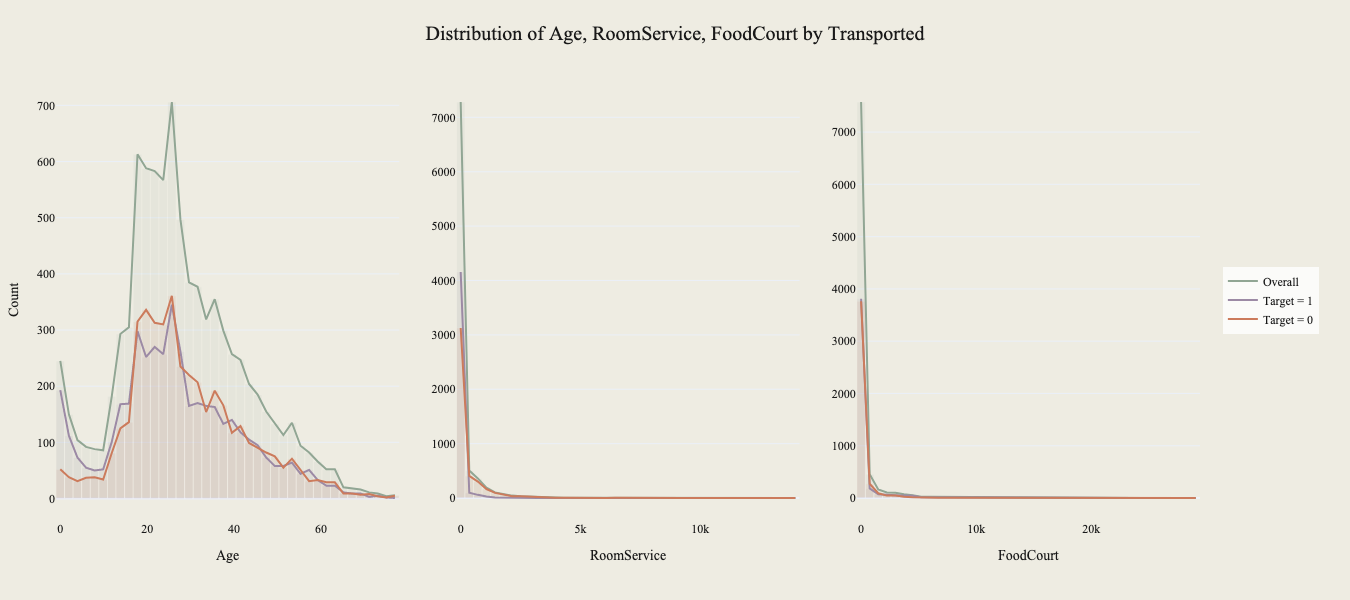

In [12]:
Image(filename="../images/numerical_features_one.png")

**Age:**

- Normal distribution peaking at 20-30 years for all groups.
- Transported group slightly higher across most ages.

**RoomService:**

- Extreme right skew for all groups.
- Transported group has higher spike at lowest values.

**FoodCourt:**

- Highly right-skewed for all groups.
- Large spike at lowest values across all categories.
- Not Transported group shows slightly lower overall spending.


In [13]:
plot_numeric_distributions(
    train_data,
    numerical_features_two,
    "Transported",
    nbins=40,
    save_path="../images/numerical_features_two.png",
)

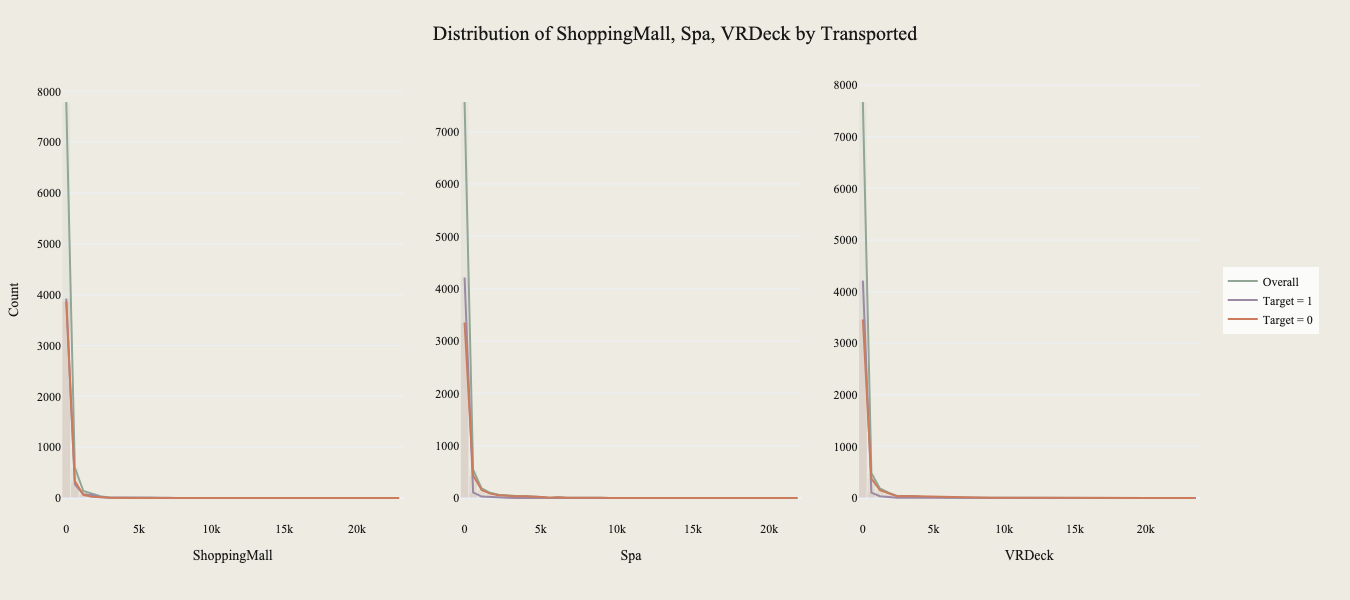

In [14]:
Image(filename="../images/numerical_features_two.png")

**ShoppingMall:**

- Extreme right skew for all groups.
- Huge spike at lowest values across all categories.
- Minimal differences between Transported and Not Transported groups.

**Spa:**

- Nearly identical pattern to ShoppingMall.
- Extreme right skew with large spike at lowest values for all groups.
- Transported group shows slightly higher spike at low values.

**VRDeck:**

- Right-skewed for all groups, but less extreme than ShoppingMall and Spa.
- Large spike at lowest values, but smaller than other amenities.
- Transported group shows slightly higher spike at low values.

Next up, let's move on to checking the distributions of our categorical features using bar plots.


In [15]:
categorical_features = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

In [16]:
plot_categorical_features_by_target(
    train_data,
    categorical_features,
    "Transported",
    save_path="../images/categorical_vs_transported.png",
)

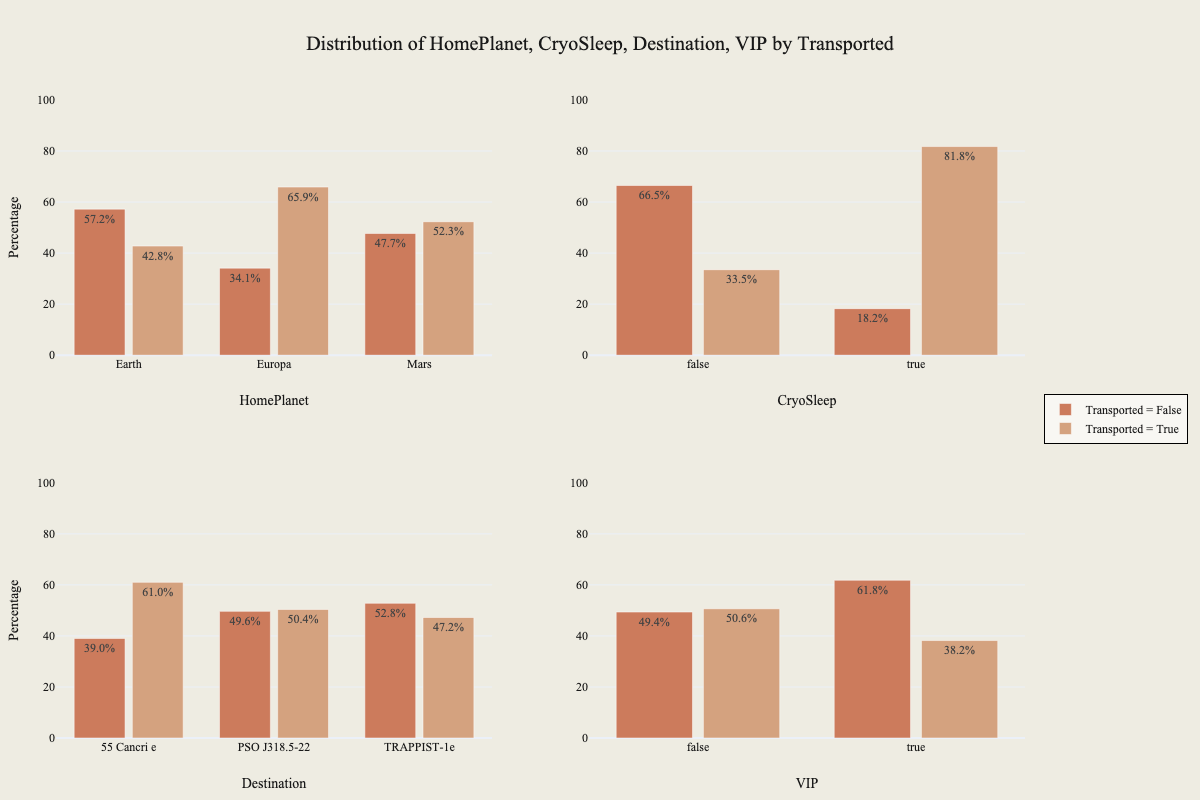

In [17]:
Image(filename="../images/categorical_vs_transported.png")

1. **HomePlanet:**

- Earth: 57.2% not transported, 42.8% transported
- Europa: 34.1% not transported, 65.9% transported
- Mars: 47.7% not transported, 52.3% transported
- Europa has the highest transport rate, while Earth has the lowest.

2. **CryoSleep:**

- False: 66.5% not transported, 33.5% transported
- True: 18.2% not transported, 81.8% transported
- Passengers in CryoSleep were much more likely to be transported.

3. **Destination:**

- 55 Cancri e: 39% not transported, 61% transported
- PSO J318.5-22: 49.6% not transported, 50.4% transported
- TRAPPIST-1e: 52.8% not transported, 47.2% transported
- 55 Cancri e shows the highest transport rate among destinations.

4. **VIP:**

- False: 49.4% not transported, 50.6% transported
- True: 61.8% not transported, 38.2% transported
- VIP status seems to have minimal impact on transport likelihood.

**In summary, none of these categorical features follow a normal distribution, which is expected for categorical variables. They show varying degrees of imbalance across their categories. This imbalance is particularly pronounced for binary features like CryoSleep and VIP**

**Next up, we can check the distribution of our target variable (Transported) using a bar plot.**


In [18]:
plot_single_bar_chart(
    train_data,
    "Transported",
    save_path="../images/target_distribution.png",
)

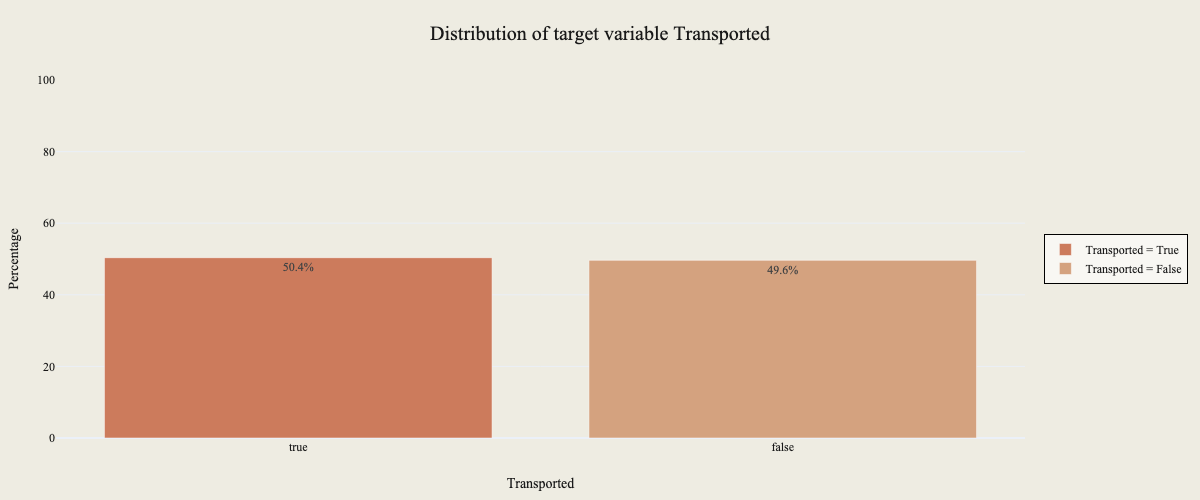

In [19]:
Image(filename="../images/target_distribution.png")

We can see that **Transported:** has a nearly balanced distribution between transported (true) and not transported (false) passengers, with slightly more transported.

Next, we can check for any correlations between our numerical features using a correlation matrix.


In [20]:
plot_correlation_matrix(
    train_data,
    numerical_features,
    save_path="../images/correlation_matrix.png",
)

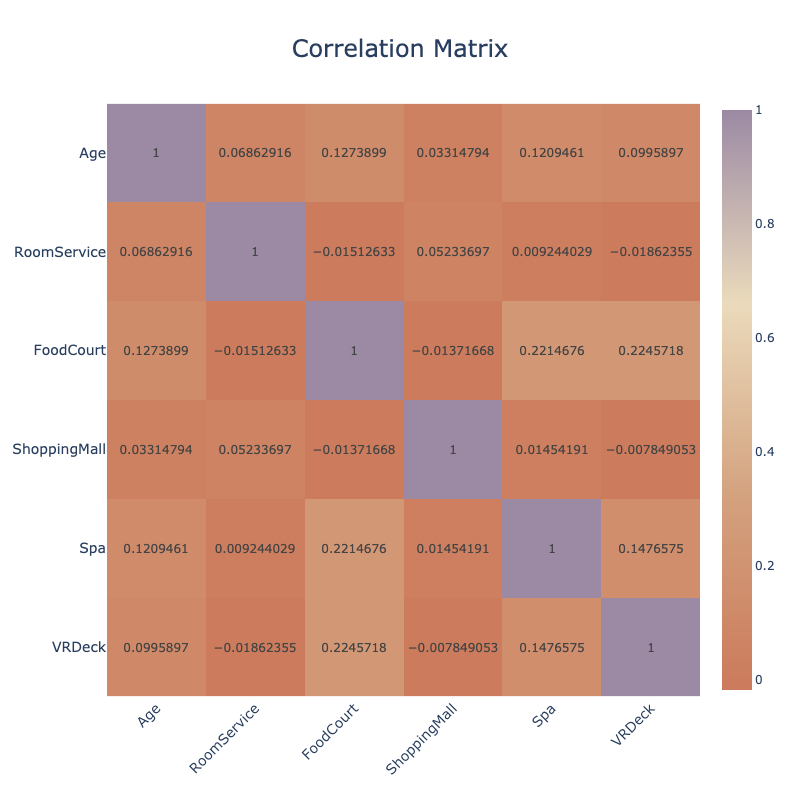

In [21]:
Image(filename="../images/correlation_matrix.png")

1. **Most correlations are weak (close to 0):** Most features don't have strong relationships with each other, as their correlations are close to zero.

2. **Strongest correlation is between FoodCourt and VRDeck (0.2246):** The strongest connection is between FoodCourt and VRDeck, with a correlation of 0.2246, which is still pretty weak.

3. **Age has weak positive correlations with all other features:** Age has weak, positive relationships with the other features, with the highest being with FoodCourt (0.1274) and Spa (0.1209).

4. **RoomService has a very weak negative correlation with FoodCourt (-0.0151):** RoomService and FoodCourt have a very slight negative relationship, with a correlation of -0.0151.

Next we can check for outliers in our numerical features using a box plot.


In [22]:
plot_combined_boxplots(
    train_data,
    numerical_features_one,
    save_path="../images/box_plots_one.png",
)

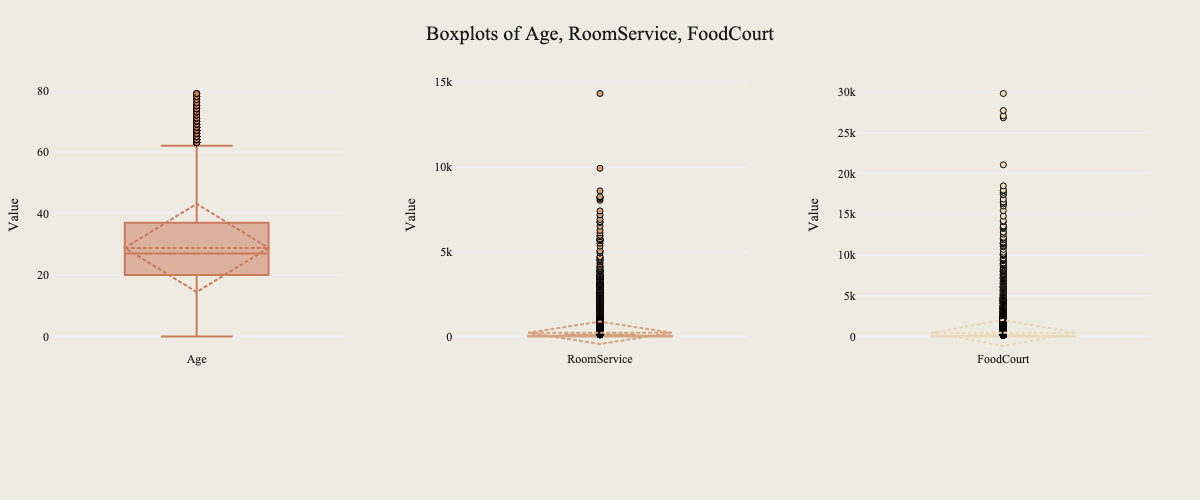

In [23]:
Image(filename="../images/box_plots_one.png")

We found some outliers in the first set of numerical features.

Now, let’s take a look at the second group of numerical features to see if we spot any more outliers or similar patterns.


In [24]:
plot_combined_boxplots(
    train_data,
    numerical_features_two,
    save_path="../images/box_plots_two.png",
)

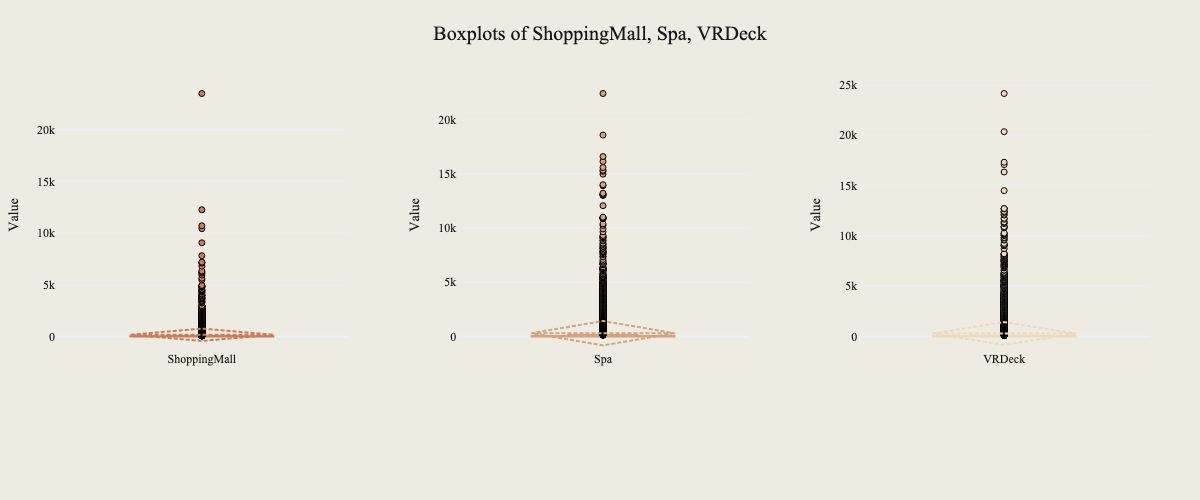

In [25]:
Image(filename="../images/box_plots_two.png")

We’ve noticed that **both sets of numerical features have a lot of outliers.**

These extreme values might affect how well our model works and the accuracy of our insights.

To deal with this, we’ll take a closer look at these outliers.


In [26]:
anomalies = detect_anomalies_iqr(train_data, numerical_features)
print("Number of anomalies detected:", len(anomalies))

Anomalies detected in feature 'Age':
     PassengerId HomePlanet  CryoSleep     Cabin    Destination   Age    VIP  \
109      0113_01      Earth      False    F/23/P    TRAPPIST-1e  64.0  False   
118      0126_01       Mars       True    F/27/S    TRAPPIST-1e  67.0  False   
248      0270_01      Earth      False    F/59/P    TRAPPIST-1e  63.0  False   
280      0310_01     Europa      False   G/734/S    TRAPPIST-1e  67.0  False   
335      0377_01     Europa      False    C/15/S    55 Cancri e  63.0  False   
...          ...        ...        ...       ...            ...   ...    ...   
8254     8816_05     Europa      False   B/340/S    TRAPPIST-1e  64.0  False   
8288     8852_01       Mars       True   D/278/P    TRAPPIST-1e  76.0  False   
8369     8954_01      Earth      False  G/1452/P  PSO J318.5-22  73.0  False   
8516     9085_01     Europa      False    A/95/P    55 Cancri e  70.0  False   
8539     9118_02      Earth      False  G/1482/P    TRAPPIST-1e  64.0  False   

  

The anomaly detection report found **5,058 anomalies** across six features: **Age**, **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, and **VRDeck**.

Since so many records are flagged as anomalies, **removing them would result in losing a lot of important data**.

Instead, we should create a new binary feature called **"IsAnomaly"**. This will **keep the original data intact** and help us **identify passengers with unusual behavior**.

This approach will **make further analysis easier** and could **improve model performance** by considering these unusual cases.

The "IsAnomaly" feature will act as a **clear marker for anomalies** in the dataset.


In [27]:
train_data["IsAnomaly"] = flag_anomalies(train_data, numerical_features)
test_data["IsAnomaly"] = flag_anomalies(test_data, numerical_features)

As we have our outliers marked as anomalies, we can proceed with our statistical inference analysis. We will conduct three statistical tests to explore relationships between key variables and the likelihood of being transported:

1. **CryoSleep Test:** Examine if there's a significant difference in **transportation rates between passengers** in CryoSleep and those who are not.
2. **HomePlanet Test:** Investigate if there's an association between a passenger's home planet and their likelihood of being **transported.**
3. **RoomService Spending Test:** Determine if the mean RoomService spending differs **between transported and non-transported passengers.**

Additionally, we'll calculate Cramer's V for categorical variables to measure their association with the 'Transported' variable.

**Our target population is all passengers on interstellar spaceships similar to the Spaceship Titanic.**


In [28]:
# Test 1: CryoSleep and Transportation
cryo_transported = train_data[train_data["CryoSleep"] == True][
    "Transported"
].mean()
non_cryo_transported = train_data[train_data["CryoSleep"] == False][
    "Transported"
].mean()
_, p_value_cryo = stats.ttest_ind(
    train_data[train_data["CryoSleep"] == True]["Transported"],
    train_data[train_data["CryoSleep"] == False]["Transported"],
)

print(f"CryoSleep Test: p-value = {p_value_cryo}")
print(f"Transportation rate for CryoSleep passengers: {cryo_transported:.2f}")
print(
    f"Transportation rate for non-CryoSleep passengers: {non_cryo_transported:.2f}"
)

CryoSleep Test: p-value = 0.0
Transportation rate for CryoSleep passengers: 0.82
Transportation rate for non-CryoSleep passengers: 0.34


In [29]:
# Test 2: HomePlanet and Transportation
home_planet_transported = train_data.groupby("HomePlanet")["Transported"].mean()
chi2, p_value_planet, _, _ = stats.chi2_contingency(
    pd.crosstab(train_data["HomePlanet"], train_data["Transported"])
)

print(f"\nHomePlanet Test: p-value = {p_value_planet}")
print("Transportation rates by HomePlanet:")
print(home_planet_transported)


HomePlanet Test: p-value = 5.549631517016864e-70
Transportation rates by HomePlanet:
HomePlanet
Earth     0.427649
Europa    0.658846
Mars      0.523024
Name: Transported, dtype: float64


In [30]:
# Test 3: RoomService Spending and Transportation
transported_spending = train_data[train_data["Transported"] == True][
    "RoomService"
]
non_transported_spending = train_data[train_data["Transported"] == False][
    "RoomService"
]
_, p_value_spending = stats.ttest_ind(
    transported_spending, non_transported_spending
)

print(f"\nRoomService Spending Test: p-value = {p_value_spending}")
print(
    f"Mean RoomService spending for transported passengers: {transported_spending.mean():.2f}"
)
print(
    f"Mean RoomService spending for non-transported passengers: {non_transported_spending.mean():.2f}"
)


RoomService Spending Test: p-value = 3.205393746705266e-115
Mean RoomService spending for transported passengers: 61.90
Mean RoomService spending for non-transported passengers: 380.43


In [31]:
cat_vars = ["HomePlanet", "CryoSleep", "Destination", "VIP"]
print("\nCramer's V for categorical variables:")
for var in cat_vars:
    cramers_v = calculate_cramers_v(train_data[var], train_data["Transported"])
    print(f"{var}: {cramers_v:.4f}")


Cramer's V for categorical variables:
HomePlanet: 0.1915
CryoSleep: 0.4599
Destination: 0.1102
VIP: 0.0365


1. **CryoSleep and Transportation:**

   - **Significance:** The p-value is 0, indicating a highly significant relationship between CryoSleep status and transportation.
   - **Effect:** 82% of CryoSleep passengers were transported compared to 34% of non-CryoSleep passengers.
   - **Cramer's V:** 0.4599, which indicates a moderate to strong association.

2. **HomePlanet and Transportation:**

   - **Significance:** The p-value is extremely low (5.55e-70), showing a significant relationship between HomePlanet and transportation.
   - **Transport Rates:** Europa has the highest transport rate at 66%, followed by Mars at 52%, and Earth at 43%.
   - **Cramer's V:** 0.1915, indicating a weak to moderate association.

3. **RoomService Spending and Transportation:**

   - **Significance:** The p-value is extremely low (3.21e-115), indicating a highly significant difference in spending between transported and non-transported passengers.
   - **Effect:** Non-transported passengers spend significantly more on RoomService (mean of 380.43) compared to transported passengers (mean of 61.90).

4. **Other Variables:**
   - **Destination:** Cramer's V is 0.1102, showing a weak association with transportation.
   - **VIP Status:** Cramer's V is 0.0365, indicating a negligible association with transportation.

**Key Insights:**

1. **CryoSleep:** This is the strongest predictor of whether a passenger was transported.
2. **HomePlanet and RoomService:** Both are significant predictors of transportation.

**Next, we will calculate the confidence intervals for the overall transportation rate and for the transportation rate among CryoSleep passengers. Based on our tests, CryoSleep status is the most significant predictor of whether a passenger was transported.**


In [32]:
# Confidence interval for overall transportation rate
overall_ci = confidence_interval(train_data["Transported"])
print(
    f"Overall transportation rate: {overall_ci[0]:.2f} (95% CI: {overall_ci[1]:.2f} - {overall_ci[2]:.2f})"
)

# Confidence interval for CryoSleep transportation rate
cryo_ci = confidence_interval(
    train_data[train_data["CryoSleep"] == True]["Transported"]
)
print(
    f"CryoSleep transportation rate: {cryo_ci[0]:.2f} (95% CI: {cryo_ci[1]:.2f} - {cryo_ci[2]:.2f})"
)

Overall transportation rate: 0.50 (95% CI: 0.49 - 0.51)
CryoSleep transportation rate: 0.82 (95% CI: 0.80 - 0.83)


- **Overall Transportation Rate:** The transportation rate across all passengers is 50%, with a 95% confidence interval (CI) ranging from 49% to 51%. This means that we can be 95% confident that the true transportation rate for the entire population lies between 49% and 51%. This indicates that, on average, about half of the passengers were transported.

- **CryoSleep Transportation Rate:** Among passengers who were in CryoSleep, the transportation rate is significantly higher at 82%, with a 95% confidence interval ranging from 80% to 83%. This means we can be 95% confident that the true transportation rate for CryoSleep passengers is between 80% and 83%. This high rate confirms that CryoSleep status is a strong predictor of being transported, as a large majority of CryoSleep passengers were successfully transported.

Given these insights, we will now proceed with feature engineering to improve our model.

**Feature Engineering Plan:**

1. **Primary Features:**

   - **TotalSpending:** Sum of RoomService, FoodCourt, ShoppingMall, Spa, VRDeck.
   - **Cabin Information:**
     - **CabinDeck:** First character of Cabin.
     - **CabinNumber:** Middle part of Cabin (as a float).
     - **CabinSide:** Last character of Cabin.
   - **Group Information:**
     - **GroupSize:** Count based on GroupId.

2. **Derived Features:**

   - **AgeGroup:** Categories of Child (0-18), Adult (18-65), Senior (65+).
   - **HomePlanetCryoSleep:** Interaction term between HomePlanet and CryoSleep.

3. **Focus Areas:**
   - Leverage CryoSleep as the primary predictor.
   - Create interaction terms with CryoSleep.
   - Develop features based on spending patterns.
   - Explore non-linear relationships in numerical variables.

**Next Steps:**

We will perform feature engineering to create new features and conduct exploratory data analysis (EDA) on some of them.


In [33]:
train_data_engineered = engineer_spaceship_features(train_data)
test_data_engineered = engineer_spaceship_features(test_data)

In [34]:
numerical_features_engineered = [
    "TotalSpending",
    "CabinNumber",
]
categorical_features_engineered_one = [
    "GroupSize",
    "AgeGroup",
    "HomePlanetCryoSleep",
]
categorical_features_engineered_two = ["CabinDeck", "CabinSide"]

In [35]:
plot_numeric_distributions(
    train_data_engineered,
    numerical_features_engineered,
    "Transported",
    save_path="../images/numerical_features_one_engineered.png",
)

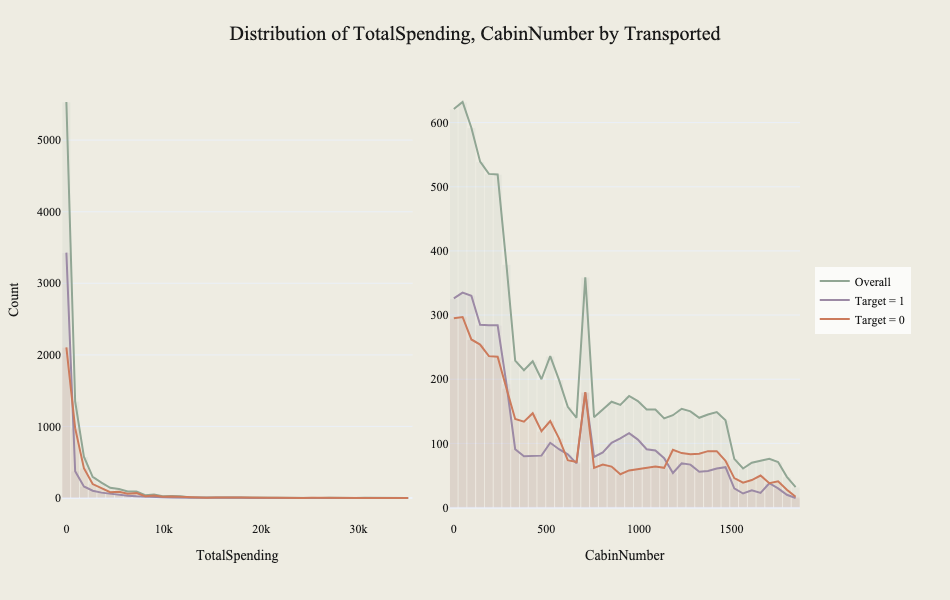

In [36]:
Image(filename="../images/numerical_features_one_engineered.png")

1. **TotalSpending:**

- The distribution is highly right-skewed, with the majority of passengers spending less than 5,000.
- There's a sharp peak at the lower end, indicating a large number of passengers with very low total spending.
- Transported passengers (Target = 1) generally have lower total spending compared to non-transported passengers (Target = 0).
- A small number of high spenders exist, with some spending over 30,000. These tend to be mostly non-transported passengers.

2. **CabinNumber:**

- The distribution across cabin numbers is more uniform compared to TotalSpending, but still shows some variation.
- There's a general downward trend in passenger count as cabin numbers increase.
- Several peaks in passenger count are visible, with notable ones around cabin numbers 300-400 and near 800.
- Transported passengers (Target = 1) seem to be more prevalent in lower cabin numbers, while non-transported passengers (Target = 0) are more common in higher cabin numbers.
- The overall passenger count decreases for cabin numbers above about 1000.


In [37]:
plot_categorical_features_by_target(
    train_data_engineered,
    categorical_features_engineered_one,
    "Transported",
    save_path="../images/categorical_features_one_engineered.png",
)

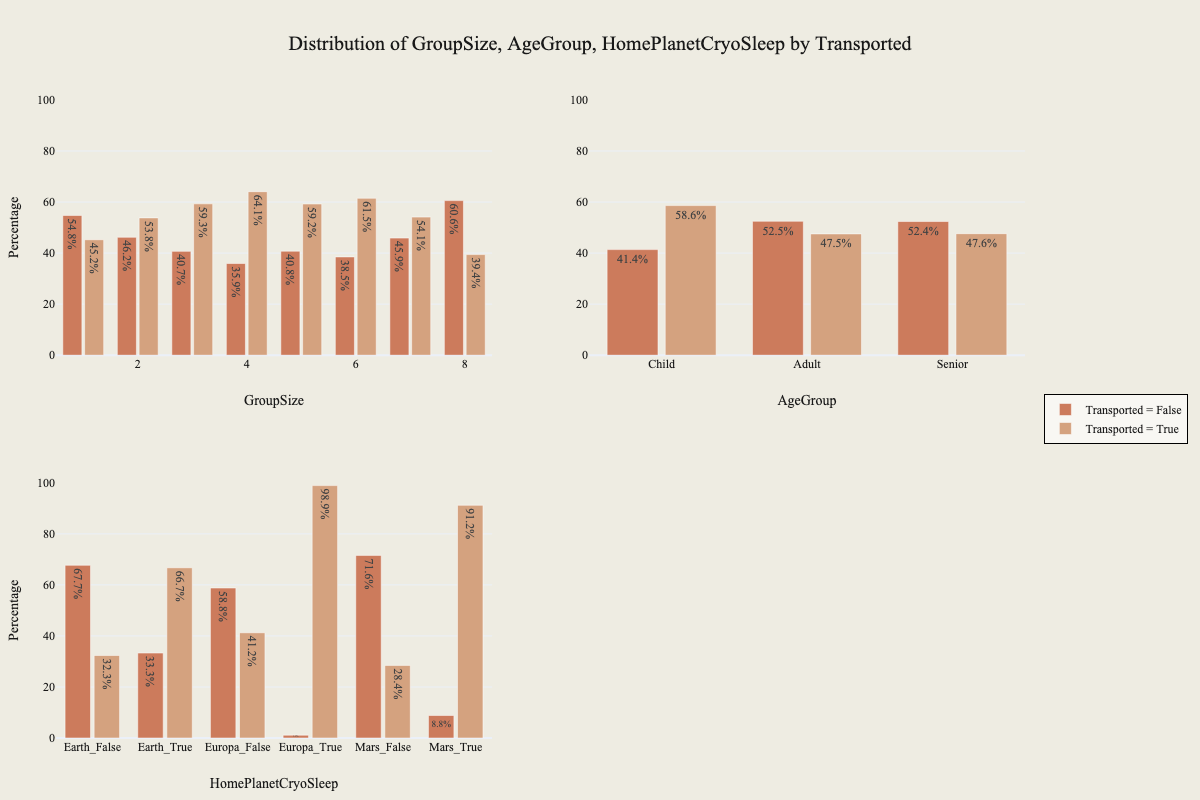

In [38]:
Image(filename="../images/categorical_features_one_engineered.png")

1. **GroupSize:**

   - Most passengers travel in groups of 1-3.
   - Larger group sizes (6-8) have higher transportation rates.
   - Solo travelers (group size 1) are less likely to be transported.

2. **AgeGroup:**

   - Children have the highest transportation rate (58.6%).
   - Adults have the lowest transportation rate (47.5%).
   - Seniors are slightly more likely to be transported than adults.

3. **HomePlanetCryoSleep:**
   - CryoSleep dramatically increases transportation likelihood across all planets.
   - Europa has the highest transportation rates, both with and without CryoSleep.
   - Earth has the lowest transportation rates, especially without CryoSleep.
   - Mars shows intermediate transportation rates.


In [39]:
plot_categorical_features_by_target(
    train_data_engineered,
    categorical_features_engineered_two,
    "Transported",
    save_path="../images/categorical_features_two_engineered.png",
)

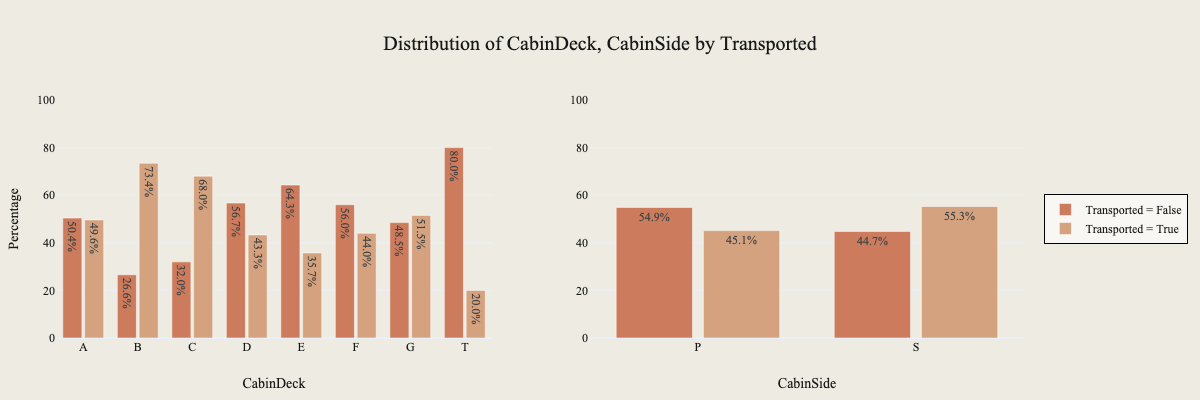

In [40]:
Image(filename="../images/categorical_features_two_engineered.png")

4. **CabinDeck:**

   - Decks B and C have the highest transportation rates.
   - Deck T has the lowest transportation rate.
   - Other decks show relatively balanced transportation rates.

5. **CabinSide:**
   - Slight difference in transportation rates between sides.
   - S side has a marginally higher transportation rate (55.3%) compared to P side (45.1%).

**Next up we can move to the modelling part**


In [41]:
# Split features and target
X = train_data_engineered.drop(["Transported", "Name", "PassengerId"], axis=1)
y = train_data_engineered["Transported"]

In [42]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [43]:
# Define features
categorical_features = [
    "HomePlanet",
    "CryoSleep",
    "Destination",
    "VIP",
    "CabinDeck",
    "CabinSide",
    "AgeGroup",
    "HomePlanetCryoSleep",
    "IsAnomaly",
]
numeric_features = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "TotalSpending",
    "CabinNumber",
    "GroupSize",
]

In [44]:
# Custom transformer for binding outliers
class OutlierBinder(BaseEstimator, TransformerMixin):
    def __init__(self, columns, lower_quantile=0.01, upper_quantile=0.99):
        self.columns = columns
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.lower_bounds = {}
        self.upper_bounds = {}

    def fit(self, X, y=None):
        for column in self.columns:
            self.lower_bounds[column] = X[column].quantile(self.lower_quantile)
            self.upper_bounds[column] = X[column].quantile(self.upper_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in self.columns:
            X_copy[column] = X_copy[column].clip(
                self.lower_bounds[column], self.upper_bounds[column]
            )
        return X_copy

In [45]:
# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                [
                    ("outlier_binder", OutlierBinder(numeric_features)),
                    ("scaler", StandardScaler()),
                ]
            ),
            numeric_features,
        ),
        (
            "cat",
            Pipeline(
                [
                    (
                        "imputer",
                        SimpleImputer(
                            strategy="constant", fill_value="missing"
                        ),
                    ),
                    ("onehot", OneHotEncoder(handle_unknown="ignore")),
                ]
            ),
            categorical_features,
        ),
    ]
)

In [46]:
# Define models
models = {
    "Dummy Classifier": DummyClassifier(strategy="stratified", random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
}

In [47]:
results = {}
for name, model in models.items():
    pipeline = create_pipeline(preprocessor, model)
    scores = cross_val_score(pipeline, X, y, cv=5, scoring="roc_auc")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    results[name] = {
        "roc_auc_cv": scores.mean(),
        "roc_auc_cv_std": scores.std(),
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_pred_proba),
        "avg_precision": average_precision_score(y_test, y_pred_proba),
    }

In [48]:
for name, metrics in results.items():
    print(f"\n{name} Results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

plot_model_performance(
    results,
    ["accuracy", "precision", "recall", "f1", "roc_auc", "avg_precision"],
    save_path="../images/model_performance.png",
)


Dummy Classifier Results:
roc_auc_cv: 0.4945
roc_auc_cv_std: 0.0072
accuracy: 0.5003
precision: 0.5052
recall: 0.4989
f1: 0.5020
roc_auc: 0.5003
avg_precision: 0.5050

Logistic Regression Results:
roc_auc_cv: 0.8789
roc_auc_cv_std: 0.0074
accuracy: 0.7832
precision: 0.7618
recall: 0.8303
f1: 0.7946
roc_auc: 0.8759
avg_precision: 0.8884

Random Forest Results:
roc_auc_cv: 0.8729
roc_auc_cv_std: 0.0143
accuracy: 0.7821
precision: 0.8032
recall: 0.7528
f1: 0.7772
roc_auc: 0.8755
avg_precision: 0.8935

XGBoost Results:
roc_auc_cv: 0.8747
roc_auc_cv_std: 0.0235
accuracy: 0.7970
precision: 0.7993
recall: 0.7984
f1: 0.7989
roc_auc: 0.8924
avg_precision: 0.9085


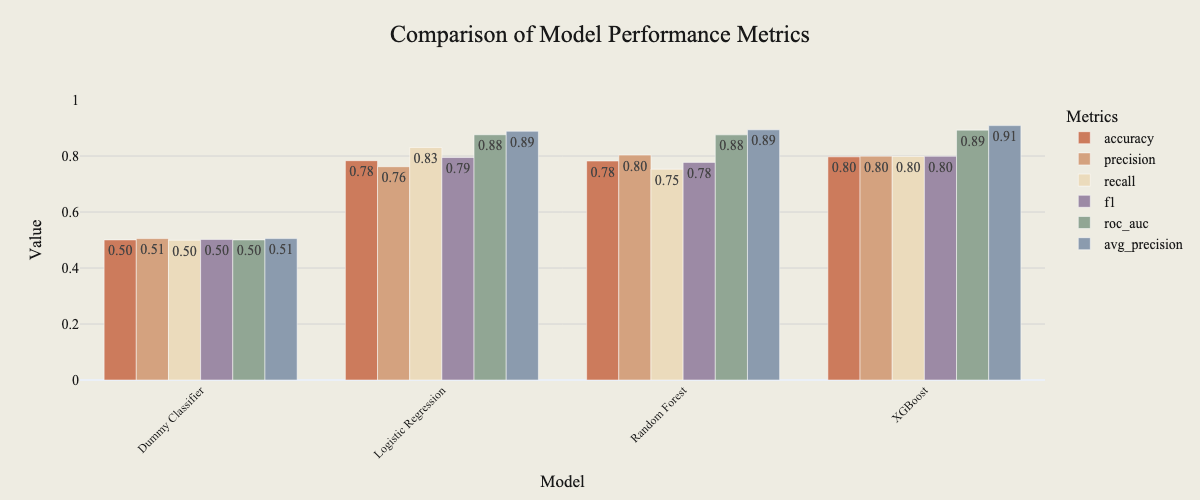

In [49]:
Image(filename="../images/model_performance.png")

From the chart, we can see that XGBoost performs the best across almost all metrics, followed closely by Random Forest.

Both significantly outperform the Dummy Classifier baseline.

Logistic Regression also shows good performance, especially in terms of recall.

Therefore, we are going to tune the model using optuna bayesian alternative for it.


In [ ]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "learning_rate": trial.suggest_float(
            "learning_rate", 1e-3, 1.0, log=True
        ),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }

    model = XGBClassifier(**params, random_state=42)

    pipeline = create_pipeline(preprocessor, model)

    scores = cross_val_score(pipeline, X, y, cv=5, scoring="roc_auc")
    return scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best hyperparameters:", study.best_params)
print("Best ROC AUC score:", study.best_value)

In [51]:
# Train final model with best hyperparameters
best_model = XGBClassifier(**study.best_params, random_state=42)
final_pipeline = create_pipeline(preprocessor, best_model)
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('outlier_binder',
                                                                   OutlierBinder(columns=['Age',
                                                                                          'RoomService',
                                                                                          'FoodCourt',
                                                                                          'ShoppingMall',
                                                                                          'Spa',
                                                                                          'VRDeck',
                                                                                          'TotalSpending',
                                                                                          'CabinNumber',
                                                                                          'GroupSize'])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck',
                                                   'TotalSpending',
                                                   'Cabin...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.007685675437947061, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=10,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=850,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

In [52]:
# Evaluate final model
y_pred = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]
final_results = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_proba),
    "avg_precision": average_precision_score(y_test, y_pred_proba),
}

print("\nFinal Model Results:")
for metric, value in final_results.items():
    print(f"{metric}: {value:.4f}")


Final Model Results:
accuracy: 0.8028
precision: 0.8016
recall: 0.8098
f1: 0.8057
roc_auc: 0.8978
avg_precision: 0.9130


In [87]:
plot_roc_curve(y_test, y_pred_proba, save_path="../images/roc_curve.png")

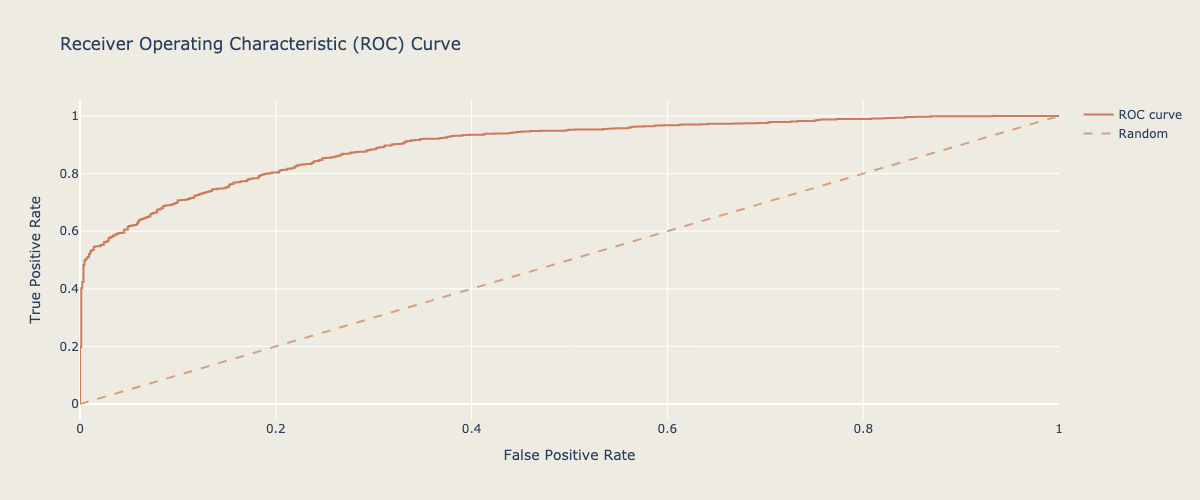

In [88]:
Image(filename="../images/roc_curve.png")

The ROC curve demonstrates excellent model performance, with the curve far above the random baseline and an area under the curve appearing to be around 0.9.

This indicates strong discriminative ability, with the True Positive Rate rising sharply for low False Positive Rates, suggesting good model sensitivity.


In [89]:
plot_precision_recall_curve(
    y_test, y_pred_proba, save_path="../images/pr_curve.png"
)

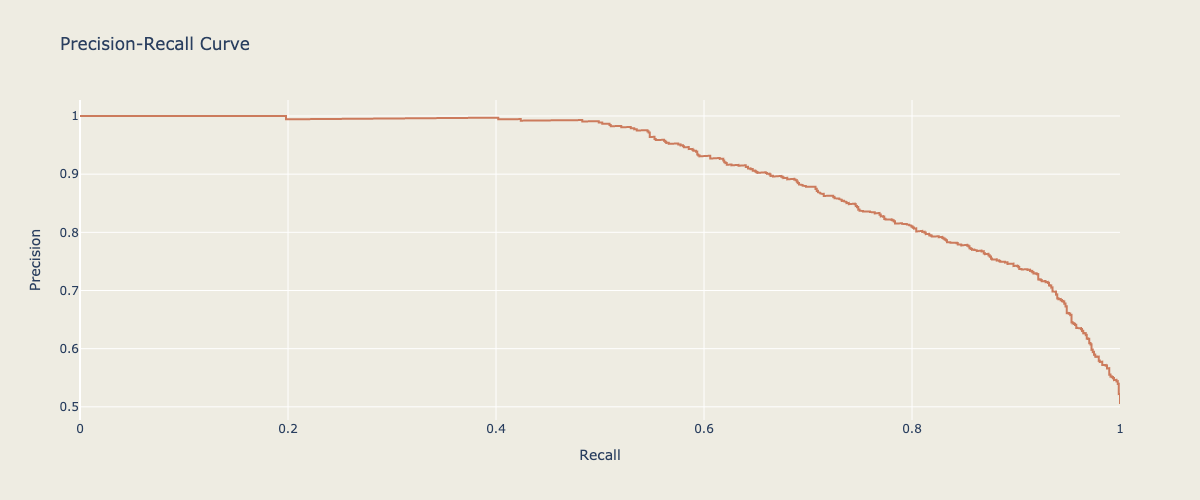

In [90]:
Image(filename="../images/pr_curve.png")

The Precision-Recall curve maintains high precision (>0.9) for recall values up to about 0.5, after which precision gradually decreases as recall increases.

The large area under the curve indicates a good balance between precision and recall across different classification thresholds.


In [91]:
plot_confusion_matrix(
    y_test, y_pred, save_path="../images/confusion_matrix.png"
)

The confusion matrix shows balanced performance with high accuracy for both transported (81.0% true positives) and not transported (79.6% true negatives) cases.

The model exhibits similar error rates for false positives (20.4%) and false negatives (19.0%), suggesting consistent performance across both classes.


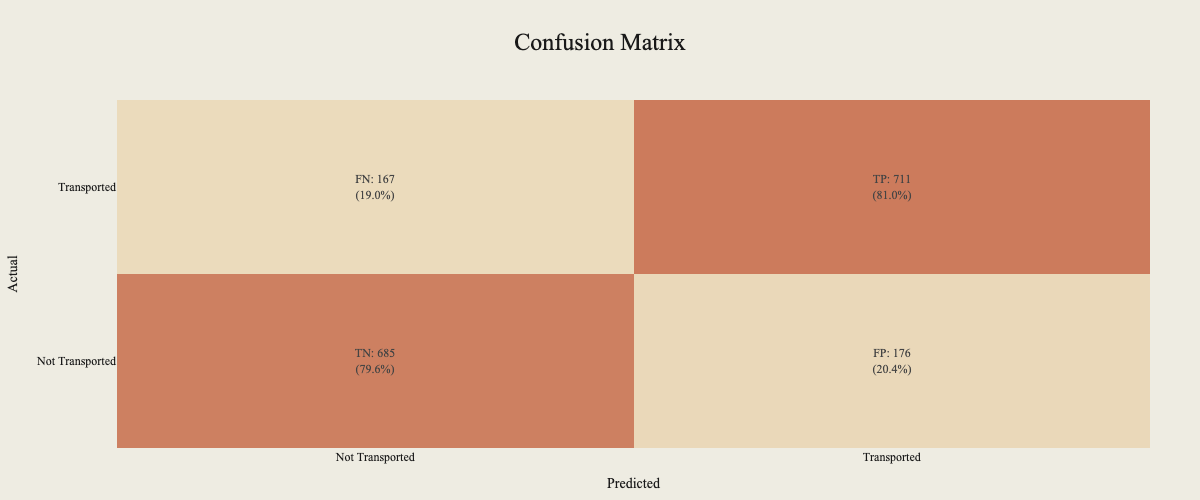

In [92]:
Image(filename="../images/confusion_matrix.png")

In [93]:
plot_learning_curve(
    final_pipeline, X, y, save_path="../images/learning_curve.png"
)

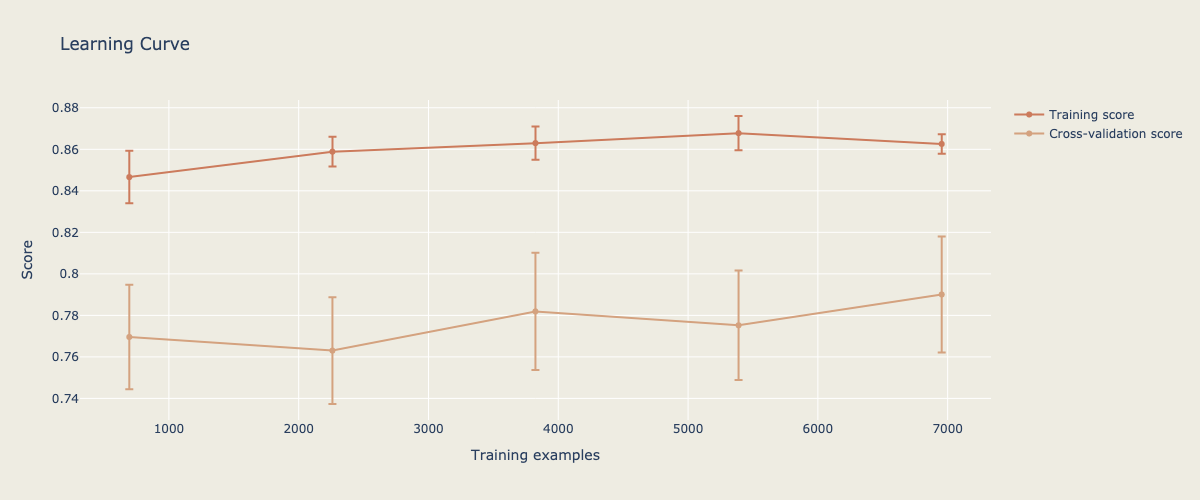

In [94]:
Image(filename="../images/learning_curve.png")

The learning curve shows a stable training score around 0.86-0.87, while the cross-validation score improves from about 0.77 to 0.79 as training examples increase.

The narrowing gap between training and cross-validation scores suggests some overfitting, but also indicates improving generalization with more data.


In [53]:
# Get feature names
def get_feature_names(column_transformer):
    feature_names = []
    for name, pipe, features in column_transformer.transformers_:
        if name == "num":
            feature_names.extend(features)
        elif name == "cat":
            oh_encoder = pipe.named_steps["onehot"]
            feature_names.extend(oh_encoder.get_feature_names_out(features))
    return feature_names


feature_names = get_feature_names(final_pipeline.named_steps["preprocessor"])

# Get feature importances
feature_importances = final_pipeline.named_steps[
    "classifier"
].feature_importances_

# Create DataFrame
feature_importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importances}
).sort_values("importance", ascending=False)

In [54]:
# Prepare the data for SHAP analysis
X_test_preprocessed = final_pipeline.named_steps["preprocessor"].transform(
    X_test
)

# Create the SHAP explainer
explainer = shap.TreeExplainer(final_pipeline.named_steps["classifier"])

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_preprocessed)

In [97]:
shap_summary_plot(
    shap_values, feature_names, save_path="../images/shap_summary_plot.png"
)

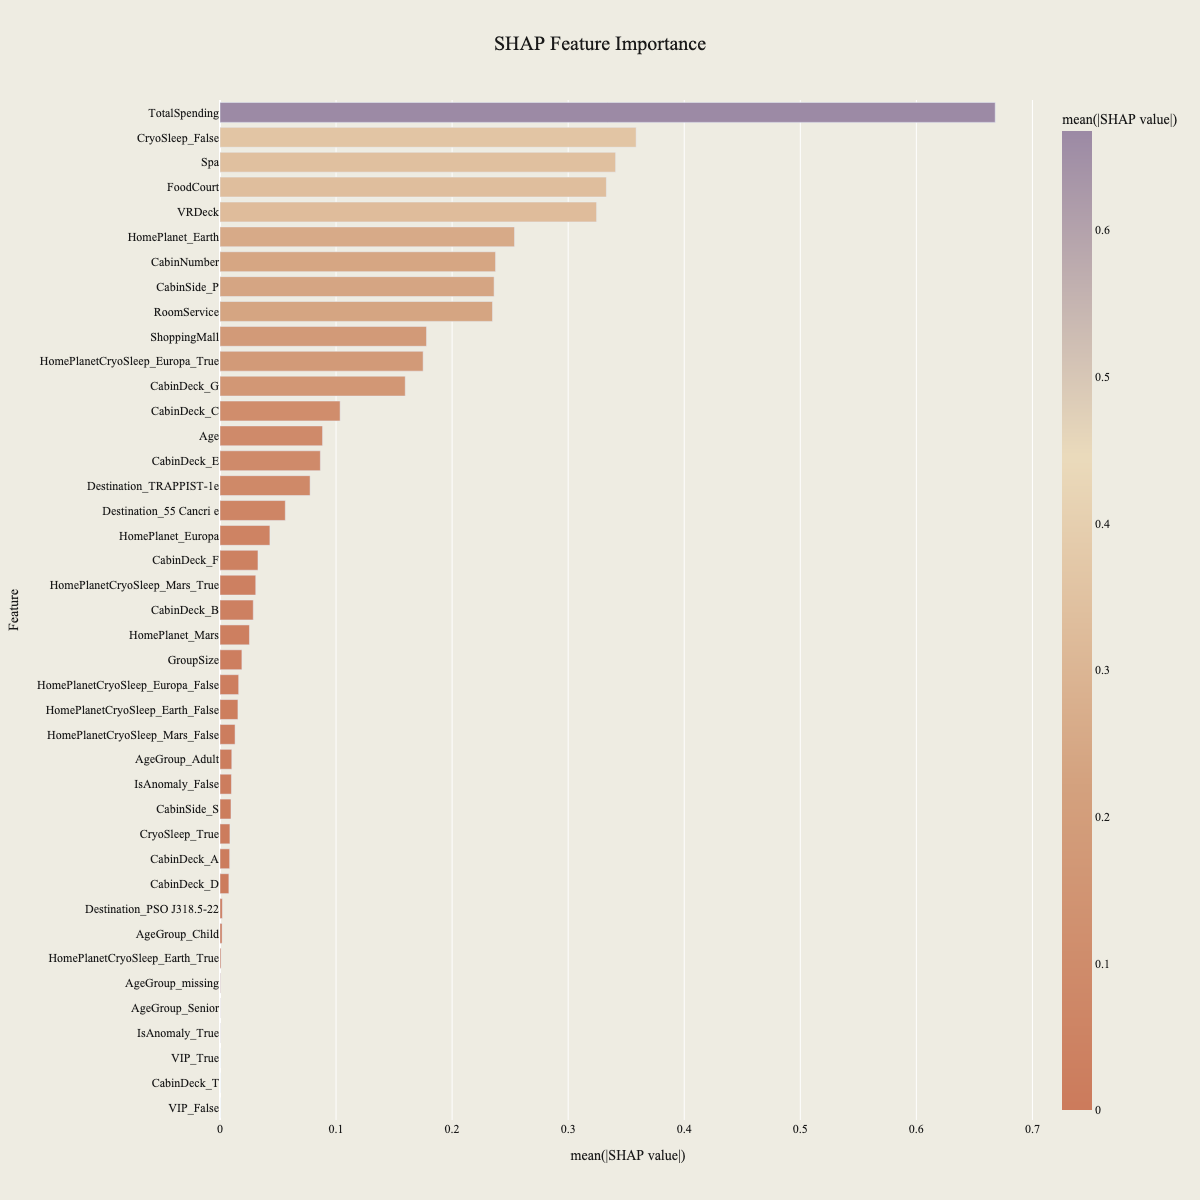

In [98]:
Image(filename="../images/shap_summary_plot.png")

**We currently have a solid XGBoost model with approximately 79.635% precision on the test data. To further improve our results, we will explore a different approach by using H2O AutoML to determine if it can surpass our current best model.**

In [ ]:
# Initialize H2O
h2o.init()

# Convert data to H2O frames
train_h2o = h2o.H2OFrame(train_data_engineered)
test_h2o = h2o.H2OFrame(test_data_engineered)

In [106]:
# Identify predictors and response
y = "Transported"
x = train_h2o.columns
x.remove(y)
x.remove("Name")
x.remove("PassengerId")

In [107]:
# Run AutoML
aml = H2OAutoML(max_runtime_secs=3600, seed=42)  # Run for 1 hour
aml.train(x=x, y=y, training_frame=train_h2o)

AutoML progress: |
21:46:18.784: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),22/106
# GBM base models (used / total),16/83
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),6/20
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [162]:
best_model = aml.leader

In [163]:
predictions = best_model.predict(test_h2o)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [171]:
# Get model performance
model_performance = best_model.model_performance(test_h2o)

if model_performance is not None:
    print("AutoML Model Performance:")
    print(model_performance)

In [170]:
# Get feature importance
feature_importance = best_model.varimp(use_pandas=True)

if feature_importance is not None:
    print("AutoML Feature Importance:")
    print(feature_importance)

In [167]:
# Get the cross-validation performance of the AutoML model
cv_performance = best_model.model_performance(xval=True)
automl_auc = cv_performance.auc()

print(f"AutoML Cross-Validation ROC AUC: {automl_auc:.4f}")
print(f"XGBoost ROC AUC: {final_results['roc_auc']:.4f}")

AutoML Cross-Validation ROC AUC: 0.9047
XGBoost ROC AUC: 0.8978


We can see that AutoML performs significantly better than the XGBoost, we can try making the ensemble model of both.

In [168]:
if automl_auc > final_results["roc_auc"]:
    print("AutoML outperformed the manually tuned XGBoost model")
    use_automl = True
else:
    print("The manually tuned XGBoost model still performs best")
    use_automl = False

AutoML outperformed the manually tuned XGBoost model


In [169]:
# Make predictions on test data
if use_automl:
    predictions = best_model.predict(test_h2o)
    test_predictions = predictions["predict"].as_data_frame()
    boolean_predictions = test_predictions.values.flatten()
else:
    test_predictions = final_pipeline.predict(test_data.drop(["Name", "PassengerId"], axis=1))
    boolean_predictions = ["True" if pred == 1 else "False" for pred in test_predictions]

submission = pd.DataFrame(
    {
        "PassengerId": test_data_engineered["PassengerId"],
        "Transported": boolean_predictions,
    }
)
submission.to_csv("../data/submission.csv", index=False)
print("\nSubmission file created: submission.csv")
print(f"Model used for submission: {'H2O AutoML' if use_automl else 'XGBoost'}")

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

Submission file created: submission.csv
Model used for submission: H2O AutoML


/Users/vytautasbunevicius/kaggle-spaceship-titanic/venv/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning:

Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)




Our H2O AutoML model predicts whether a passenger was transported. 

It performs better than our previous XGBoost model, with a test accuracy of **0.80149 compared to XGBoost's 0.79635.** 

The model uses passenger information to make predictions, but doesn't use names or passenger IDs. It showed good performance on training data (AUC: 0.9746) and cross-validation (AUC: 0.9047). 

In [130]:
# Set the relative path to the desired directory
# Assumes the project is located in the user's home directory (~)
# Adjust the relative path if the project is in a different location
models_dir = os.path.expanduser("~/kaggle-spaceship-titanic/models")

# Create the models directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

if use_automl:
    # Save the H2O AutoML model
    model_path = h2o.save_model(model=best_model, path=models_dir, force=True)
    print(f"AutoML model saved to: {model_path}")
else:
    # Save the XGBoost model
    joblib.dump(final_pipeline, os.path.join(models_dir, 'xgboost_model.joblib'))
    print(f"XGBoost model saved to: {os.path.join(models_dir, 'xgboost_model.joblib')}")

# Save the choice of model
with open(os.path.join(models_dir, 'model_choice.txt'), 'w') as f:
    f.write('automl' if use_automl else 'xgboost')

print(f"Model choice saved to: {os.path.join(models_dir, 'model_choice.txt')}")

AutoML model saved to: /Users/vytautasbunevicius/kaggle-spaceship-titanic/models/StackedEnsemble_Best1000_1_AutoML_1_20240811_214618
Model choice saved to: /Users/vytautasbunevicius/kaggle-spaceship-titanic/models/model_choice.txt


**What We Learned**

We studied the Spaceship Titanic data to figure out why some passengers were transported to another dimension. We used both traditional methods and new automatic machine learning tools.

**Main Findings:**

- **CryoSleep** was the biggest factor. 82% of people in CryoSleep were transported, but only 34% of others were.
- Where passengers came from mattered. More people from Europa were transported than from Mars or Earth.
- People who spent less money on the ship were more likely to be transported.
- Other things that mattered included where passengers' cabins were, how big their groups were, and how old they were.

**How We Studied This:**

- We cleaned up the data and fixed any missing information.
- We created new useful information from the existing data.
- We used statistics to understand what was important.
- We tried different types of computer programs to predict who would be transported.
- We used a special tool to make our best program (XGBoost) even better.
- We also used an automatic tool (AutoML) to see if it could do even better.

**How Well Our Predictions Worked:**

1. Our best manual method (XGBoost):
   - Got it right 80.28% of the time.
   - Had a special score (ROC AUC) of 0.8978 out of 1.

2. The automatic method (AutoML):
   - Did even better than our manual method.

**What We Concluded:**

Using both traditional methods and new automatic tools gave us the best results. Our final program can help predict who might be transported if this happens again. This could be useful for rescue missions or making space travel safer.

**What We Could Do Next:**

- Look closer at how the automatic tool made its decisions.
- Try combining our manual method with the automatic one.
- Create more useful information from the data we have.
- If we get more data about when things happened, we could study that too.
- Or lastly we could run the AutoML models longers to test bigger variety of them.

This study helps us understand the Spaceship Titanic event better and shows how we can use these methods to solve tricky problems in future space travel.